# RNNs Part 3 - LSTMs

Previously we trained 'vanilla' RNNs on the data, as split in a multitude of ways, and trying many size architectures. We got decent results, but no model surpassed 80% decoding accuracy on the test set. We will keep trying, along 3 fronts:  

1) Turn problem into a binary classification problem. We only need the next choice, so we can turn the network from sequence-to-sequence, to sequence-to-binary output. This will increase our training samples substantially.   
2) We will include other information at each time step, mainly trial #, and reaction time to initiate trial, and to make a choice  
3) We will turn to LSTMs which can learn longer dependencies. At first glance, I'm not sure that this makes sense because our sequences really aren't that long. But if other things fail to give us results, why not try ?   

Let's be more careful about training *and* validation sets here. I think previously we were being unfair by optimizing network size on testing set and presenting those same results as our final output. 



## Preparing Sequences
As before, we created an object that given a dataset, separates into training, validating, and testing sets based on sessions. Once sessions are randomly split into one of these 3 groups, we grab each session and:

1) extract features: in this case a) choice, b) reward, c) trial #, d) reaction time 1, e) reaction time 2
2) split into sequences of length 20, with y being the next choice
3) save to X_test, y_test, X_train, y_train, X_validate, y_validate fields of object

For 1) above, we first z-scored reaction time 1 (time to initiate trial) and reaction time 2 (time to make a choice), removed outliers that were more than 2 standard deviatons away from the mean, and split it into percentiles. We used 10 bins, so that if a value was in the lowest 10% percentile it got a 0, next 10% got a 1 and so on. The trial # is the trial since the session began. It may help the model get a sense of where in the session it is and whether that affects how animals make choices

In [9]:
#BOILERPLATE _______________________
#MODULES ______________________
ROOT = '/Users/pablomartin/python/'
import os
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
import pysftp
import matplotlib.pyplot as plt
from keras.models import load_model

from RNNmodule.SequenceClass import Sequences
from behavioral_performance.utils import fileNames, fileNameLabels
from Visualize.decoding import *
idx = pd.IndexSlice


Using TensorFlow backend.


In [4]:

source = ROOT + 'DATA_structures/TbyT/'
target = ROOT + 'DATA_structures/RNN_sequences/binary/'
seq_length = 20
RANDOM_STATE = 11

for dataset in [d for d in os.listdir(source) if not d.startswith('.')]:
    #create Sequence object
    SeqObject = Sequences('binary', 'by%i' %seq_length, RANDOM_STATE = RANDOM_STATE)
    #loading dataset
    df = pickle.load(open(source + dataset, 'rb'))
    #create sequences!
    SeqObject.create_sequences(df, timesteps = seq_length)
    #save object
    pickle.dump(SeqObject, open(target + dataset, 'wb'))
print 'DONE.'
    

/Users/pablomartin/python/RNNmodule/SequenceClass.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['trial_counter'] = np.arange(len(df))


DONE.


## Training Models
As always, we will do this in parallel. We have some options here, the number of LSTM cells to include, and the number of layers to include. How many epochs to train for ? 

on epoch 0/200
on epoch 10/200
on epoch 20/200
on epoch 30/200
on epoch 40/200
on epoch 50/200
on epoch 60/200
on epoch 70/200
on epoch 80/200
on epoch 90/200
on epoch 100/200
on epoch 110/200
on epoch 120/200
on epoch 130/200
on epoch 140/200
on epoch 150/200
on epoch 160/200
on epoch 170/200
on epoch 180/200
on epoch 190/200


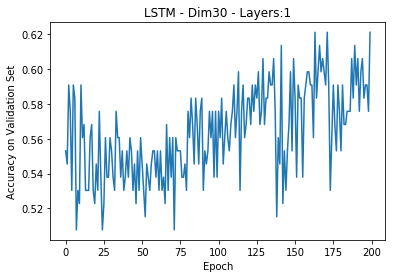

on epoch 0/200
on epoch 10/200
on epoch 20/200
on epoch 30/200
on epoch 40/200
on epoch 50/200
on epoch 60/200
on epoch 70/200
on epoch 80/200
on epoch 90/200
on epoch 100/200
on epoch 110/200
on epoch 120/200
on epoch 130/200
on epoch 140/200
on epoch 150/200
on epoch 160/200
on epoch 170/200
on epoch 180/200
on epoch 190/200


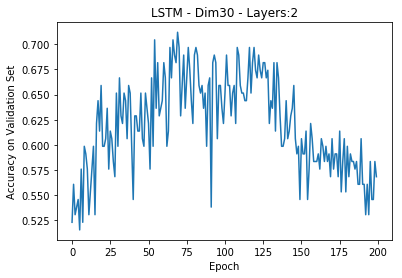

on epoch 0/200
on epoch 10/200
on epoch 20/200
on epoch 30/200
on epoch 40/200
on epoch 50/200
on epoch 60/200
on epoch 70/200
on epoch 80/200
on epoch 90/200
on epoch 100/200
on epoch 110/200
on epoch 120/200
on epoch 130/200
on epoch 140/200
on epoch 150/200
on epoch 160/200
on epoch 170/200
on epoch 180/200
on epoch 190/200


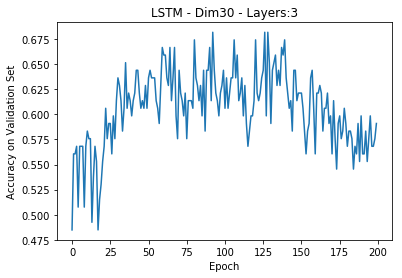

In [6]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


def train_network(seqs, hd = 30, no_epochs = 30, layers = 1):
    #create model
    model = Sequential()
    if layers == 1:
        model.add(LSTM(input_shape = (20,5), units = hd))
    elif layers == 2:
        model.add(LSTM( return_sequences=True, input_shape = (20, 5), units = hd))
        model.add(LSTM(hd))
    elif layers == 3:
        model.add(LSTM( return_sequences=True, input_shape = (20, 5), units = hd))
        model.add(LSTM( return_sequences=True, input_shape = (20, 5), units = hd))
        model.add(LSTM(hd))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    #train and evaluate per epoch
    perf = np.zeros(no_epochs)
    for epoch in range(no_epochs):
        if epoch % 10 == 0:
            print 'on epoch %i/%i' %(epoch, no_epochs)
        model.fit(x = seqs.X_train, y = seqs.y_train,
                  validation_data = (seqs.X_validate, seqs.y_validate),
                  epochs = 1,
                  batch_size = 64,
                  verbose = 0)

        scores = model.evaluate(seqs.X_validate, seqs.y_validate, verbose = 0)
        perf[epoch] = scores[1]

    #plot performance of model as it is being trained
    plt.plot(perf)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy on Validation Set')
    plt.title('LSTM - Dim%i - Layers:%i' %(hd, layers))
    plt.show()
    return


#load one of the datasets - our previous RNN models scored a maximum of ~0.75 on this dataset
seqs = pickle.load(open(ROOT + 'DATA_structures/RNN_sequences/binary/DSR_TbyT_Contra.p','rb'))
#we will see how model improves over 200 epochs for single, double, and triple layer networks
train_network(seqs, hd = 30, no_epochs = 200, layers = 1)
train_network(seqs, hd = 30, no_epochs = 200, layers = 2)
train_network(seqs, hd = 30, no_epochs = 200, layers = 3)

So there's a good bit of randomness while training, and the accuracy of the model depends a lot on the epoch you happened to pick. From these examples, it's not clear that there is a number of epochs where the model learns the best, plateaus, and then comes back down when it starts to overfit. No clear solution here.   

So I fit a bunch of models with a single, double, or triple LSTM layer with varying dimensions. We downloaded the files back into the local computer, and assess how well they did on the validation set. 

EDIT: I guess our next step is to start messing around with early stopping. This will be a different notebook, and with other things we learned from here to further optimize

In [ ]:
import itertools
import pandas as pd
from behavioral_performance.utils import fileNames
from keras.models import load_model
from RNNmodule.SequenceClass import Sequences

ROOT = '/Users/pablomartin/python/'
model_dir = ROOT + 'Models/LSTM/Pablo/Binary/'
sequence_dir = ROOT + 'DATA_structures/RNN_sequences/binary/'
Layers = ['Single', 'Double', 'Triple']
hidden_dimensions = [2, 5, 10, 20, 50, 100]
# scores = pd.DataFrame(np.zeros([14, 18]),
#                       index = fileNames,
#                       columns = pd.MultiIndex.from_product([Layers, hidden_dimensions],
#                                                            names = ['Layer', 'HD']))
idx = pd.IndexSlice

for fileName in fileNames:
    
    sequence_path = sequence_dir + fileName
    seqs = pickle.load(open(sequence_path, 'rb'))
    for Layer, hd in itertools.product(Layers, hidden_dimensions):
        
        if scores.loc[fileName, idx[Layer, hd]] == 0:
            print '%s - %s - %i' %(fileName, Layer, hd)
            model = load_model(model_dir + Layer + '/' + fileName[:-2] + str(hd) + '.h5')
            val_scores = model.evaluate(seqs.X_validate, seqs.y_validate)
            test_scores = model.evaluate(seqs.X_test, seqs.y_test)
            scores.loc[fileName, idx[Layer, hd]] = val_scores[1]
            print 'val score:%1.2f test score:%1.2f' %(val_scores[1], test_scores[1])
        else:
            print 'calculated already'
    
pickle.dump(scores, open(ROOT + 'Model_Evaluation/LSTM/binary_classification_behavior.p', 'wb'))

## Evaluate Models
We will plot the performance of each model on the validation set below. This will give us an overview of which architectures are better, and which datasets are being learned and which are not. 

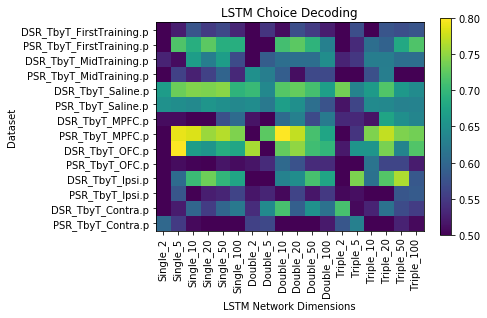

MAX SCORES ACHIEVED:
score: 0.58 - Triple_100 - DSR_TbyT_FirstTraining.p
score: 0.72 - Single_20 - PSR_TbyT_FirstTraining.p
score: 0.67 - Single_50 - DSR_TbyT_MidTraining.p
score: 0.65 - Double_2 - PSR_TbyT_MidTraining.p
score: 0.75 - Single_50 - DSR_TbyT_Saline.p
score: 0.67 - Double_10 - PSR_TbyT_Saline.p
score: 0.68 - Triple_20 - DSR_TbyT_MPFC.p
score: 0.80 - Double_10 - PSR_TbyT_MPFC.p
score: 0.80 - Single_5 - DSR_TbyT_OFC.p
score: 0.62 - Triple_10 - PSR_TbyT_OFC.p
score: 0.76 - Triple_50 - DSR_TbyT_Ipsi.p
score: 0.59 - Triple_100 - PSR_TbyT_Ipsi.p
score: 0.71 - Double_10 - DSR_TbyT_Contra.p
score: 0.63 - Triple_5 - PSR_TbyT_Contra.p


In [8]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from behavioral_performance.utils import fileNames

ROOT = '/Users/pablomartin/python/'

scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binary_classification_behavior.p', 'rb'))
labels = []
for a,b in zip(*scores.columns.labels):
    labels.append('_'.join([scores.columns.levels[0][a], str(scores.columns.levels[1][b])]))

fig = plt.imshow(scores, vmin = 0.5 , vmax = 0.8) 
plt.xticks(np.linspace(0,len(labels) - 1, len(labels)), labels, rotation=90)
plt.yticks(np.linspace(0,len(fileNames) - 1, len(fileNames)), fileNames, rotation=0)
plt.xlabel('LSTM Network Dimensions')
plt.ylabel('Dataset')
plt.title('LSTM Choice Decoding')
plt.colorbar()
plt.show()
print 'MAX SCORES ACHIEVED:'
for fileName, a,b in zip(fileNames, np.max(scores, axis=1), np.argmax(scores.values, axis=1)):
    print 'score: %1.2f - %s - %s' %(a, labels[b], fileName)

## Interpretations
Should we be surprised ? Maybe not. The results are very underwhelming, but then again, we sort of knew that LSTMs were not the right tool for the job. I guess we had to try them, and find out this way. The sequences were "only" 20 trials long, whilst most people talk about LSTMs being for sequences with 200-400 timesteps. And TONS of data, which we don't have. Let's take a step back, however, because we did define the problem a bit different this time. Here we made it into a binary classification problem, so the next step is to find out whether a vanilla RNN would do better, given that what we tried before was a bit different.  

The idea is that there would be less parameters to train with a 'vanilla' RNN, and it won't have a long-term dependency problem since the sequences are not that long. Maybe it will do better. Again, trained the models on epsilon, which did not take very long, and evaluated them here.

In [6]:
import itertools
import pandas as pd
from behavioral_performance.utils import fileNames
from keras.models import load_model
from RNNmodule.SequenceClass import Sequences

ROOT = '/Users/pablomartin/python/'
model_dir = ROOT + 'Models/RNN/binary/'
sequence_dir = ROOT + 'DATA_structures/RNN_sequences/binary/'
Layers = ['Single', 'Double', 'Triple']
hidden_dimensions = [2, 5, 10, 20, 50, 100]
scores = pd.DataFrame(np.zeros([14, 18]),
                      index = fileNames,
                      columns = pd.MultiIndex.from_product([Layers, hidden_dimensions],
                                                           names = ['Layer', 'HD']))
idx = pd.IndexSlice

for fileName in fileNames:
    
    sequence_path = sequence_dir + fileName
    seqs = pickle.load(open(sequence_path, 'rb'))
    for Layer, hd in itertools.product(Layers, hidden_dimensions):
        
        if scores.loc[fileName, idx[Layer, hd]] == 0:
            print '%s - %s - %i' %(fileName, Layer, hd)
            model = load_model(model_dir + Layer + '/' + fileName[:-2] + str(hd) + '.h5')
            val_scores = model.evaluate(seqs.X_validate, seqs.y_validate)
            test_scores = model.evaluate(seqs.X_test, seqs.y_test)
            scores.loc[fileName, idx[Layer, hd]] = val_scores[1]
            print 'val score:%1.2f test score:%1.2f' %(val_scores[1], test_scores[1])
        else:
            print 'calculated already'
    
pickle.dump(scores, open(ROOT + 'Model_Evaluation/RNN/binary_classification_behavior.p', 'wb'))

Using TensorFlow backend.


DSR_TbyT_FirstTraining.p - Single - 2
50/50 [==============================] - 0s 300us/step
val score:0.41 test score:0.40
DSR_TbyT_FirstTraining.p - Single - 5
50/50 [==============================] - 0s 306us/step
val score:0.48 test score:0.30
DSR_TbyT_FirstTraining.p - Single - 10
50/50 [==============================] - 0s 307us/step
val score:0.43 test score:0.44
DSR_TbyT_FirstTraining.p - Single - 20
50/50 [==============================] - 0s 354us/step
val score:0.48 test score:0.66
DSR_TbyT_FirstTraining.p - Single - 50
50/50 [==============================] - 0s 304us/step
val score:0.53 test score:0.60
DSR_TbyT_FirstTraining.p - Single - 100
50/50 [==============================] - 0s 263us/step
val score:0.52 test score:0.56
DSR_TbyT_FirstTraining.p - Double - 2
50/50 [==============================] - 0s 441us/step
val score:0.42 test score:0.60
DSR_TbyT_FirstTraining.p - Double - 5
50/50 [==============================] - 0s 464us/step
val score:0.50 test score:0.36
DSR

840/840 [==============================] - 0s 231us/step
val score:0.53 test score:0.48
PSR_TbyT_Saline.p - Single - 10
840/840 [==============================] - 0s 249us/step
val score:0.66 test score:0.68
PSR_TbyT_Saline.p - Single - 20
840/840 [==============================] - 0s 250us/step
val score:0.66 test score:0.68
PSR_TbyT_Saline.p - Single - 50
840/840 [==============================] - 0s 251us/step
val score:0.65 test score:0.69
PSR_TbyT_Saline.p - Single - 100
840/840 [==============================] - 0s 250us/step
val score:0.63 test score:0.66
PSR_TbyT_Saline.p - Double - 2
840/840 [==============================] - 0s 371us/step
val score:0.52 test score:0.47
PSR_TbyT_Saline.p - Double - 5
840/840 [==============================] - 0s 370us/step
val score:0.63 test score:0.67
PSR_TbyT_Saline.p - Double - 10
840/840 [==============================] - 0s 379us/step
val score:0.62 test score:0.63
PSR_TbyT_Saline.p - Double - 20
840/840 [==============================] 

98/98 [==============================] - 0s 556us/step
val score:0.47 test score:0.51
DSR_TbyT_Ipsi.p - Double - 5
98/98 [==============================] - 0s 618us/step
val score:0.68 test score:0.65
DSR_TbyT_Ipsi.p - Double - 10
98/98 [==============================] - 0s 607us/step
val score:0.76 test score:0.66
DSR_TbyT_Ipsi.p - Double - 20
98/98 [==============================] - 0s 562us/step
val score:0.69 test score:0.69
DSR_TbyT_Ipsi.p - Double - 50
98/98 [==============================] - 0s 684us/step
val score:0.64 test score:0.66
DSR_TbyT_Ipsi.p - Double - 100
98/98 [==============================] - 0s 569us/step
val score:0.63 test score:0.62
DSR_TbyT_Ipsi.p - Triple - 2
98/98 [==============================] - 0s 718us/step
val score:0.50 test score:0.51
DSR_TbyT_Ipsi.p - Triple - 5
98/98 [==============================] - 0s 849us/step
val score:0.47 test score:0.49
DSR_TbyT_Ipsi.p - Triple - 10
98/98 [==============================] - 0s 732us/step
val score:0.44 test

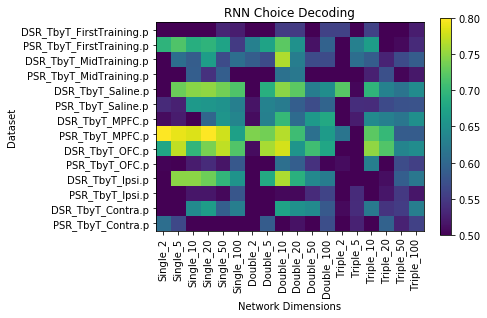

MAX SCORES ACHIEVED:
score: 0.56 - Double_100 - DSR_TbyT_FirstTraining.p
score: 0.72 - Double_10 - PSR_TbyT_FirstTraining.p
score: 0.76 - Double_10 - DSR_TbyT_MidTraining.p
score: 0.62 - Double_20 - PSR_TbyT_MidTraining.p
score: 0.75 - Single_20 - DSR_TbyT_Saline.p
score: 0.66 - Single_10 - PSR_TbyT_Saline.p
score: 0.70 - Double_10 - DSR_TbyT_MPFC.p
score: 0.82 - Single_20 - PSR_TbyT_MPFC.p
score: 0.78 - Double_10 - DSR_TbyT_OFC.p
score: 0.63 - Triple_10 - PSR_TbyT_OFC.p
score: 0.76 - Double_10 - DSR_TbyT_Ipsi.p
score: 0.58 - Single_100 - PSR_TbyT_Ipsi.p
score: 0.67 - Double_10 - DSR_TbyT_Contra.p
score: 0.61 - Single_2 - PSR_TbyT_Contra.p


In [5]:
scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binary_classification_behavior.p', 'rb'))
def plot_model_performance(scores, title):
    labels = []
    for a,b in zip(*scores.columns.labels):
        labels.append('_'.join([scores.columns.levels[0][a], str(scores.columns.levels[1][b])]))

    fig = plt.imshow(scores, vmin = 0.5 , vmax = 0.8) 
    plt.xticks(np.linspace(0,len(labels) - 1, len(labels)), labels, rotation=90)
    plt.yticks(np.linspace(0,len(fileNames) - 1, len(fileNames)), fileNames, rotation=0)
    plt.xlabel('Network Dimensions')
    plt.ylabel('Dataset')
    plt.title(title)
    plt.colorbar()
    plt.show()

    print 'MAX SCORES ACHIEVED:'
    for fileName, a,b in zip(fileNames, np.max(scores, axis=1), np.argmax(scores.values, axis=1)):
        print 'score: %1.2f - %s - %s' %(a, labels[b], fileName)

plot_model_performance(scores, 'RNN Choice Decoding')

## Comparing LSTMs and 'Vanilla' RNNs

Training similar size networks with either simple RNN or LSTM cells for the way we prepared the sequences, as a binary classification problem, yielded very similar results. Again, the sequences are not long enough to take advantage of the long-term dependencies that forget, input, and output gates provide. Also, it takes a lot less time to train vanilla RNNs. In general, we achieved similar decoding accuracy as with other 'vanilla' RNNs when we posed the problem slightly differently. We achieved marginal gains on the following datasets:  

DSR: Saline - 0.73 to 0.75  
        OFC - 0.77 to 0.80  
       Ipsi - 0.72 to 0.76  
PSR: 
        Mid - 0.64 to 0.65  
       mPFC - 0.77 to 0.82  

Not sure what to try next. Let's try the same problem formulation, i.e. binary sequence classification, but without providing the timing and trial information. This will be called the binaryMinimal sequence prepration. Only choice and reward information is inputted into the system. We will train all same architectures as before, *not* LSTM though, just fully connected RNNs. 


In [ ]:
ROOT = '/Users/pablomartin/python/'
import os
import pickle
import numpy as np
import pandas as pd
import itertools

from RNNmodule.SequenceClass import Sequences

source = ROOT + 'DATA_structures/TbyT/'
target = ROOT + 'DATA_structures/RNN_sequences/'

RANDOM_STATE = 10 #used to be 11
clean_dir = [d for d in os.listdir(source) if not d.startswith('.')]
SEQS = ['binary', 'binaryMinimal', 'binaryOmni',
        'full_binaryMinimal', 'full_binary', 'full_binaryOmni']

for seq_type, dataset  in itertools.product(SEQS, clean_dir):
    if seq_type.startswith('full'):
        seq_length = 200
    else:
        seq_length = 20
        
    #create Sequence object
    SeqObject = Sequences('binary', 'by%i' %seq_length, RANDOM_STATE = RANDOM_STATE)
    #loading dataset
    df = pickle.load(open(source + dataset, 'rb'))
    #create sequences!
    SeqObject.create_sequences(df, timesteps = seq_length, feature_dim = seq_type)
    #save object
    pickle.dump(SeqObject, open(target + seq_type + '/' + dataset, 'wb'))
print 'DONE.'

OK, sequences have been prepared and models are being trained on epsilon as always. Once those are done, this time I'm gonna evaluate them over there too ? It takes a ridiculous amount of time to do over here, but the goal will be to get the same type of diagram as above. I'm not expecting a fundamental change. In some regard, I really don't think the trial information or timing was adding to the decoding, and it may be 'distracting' to the network as it tries to fit stuff to it. However, given the # of epochs we had and size of some of these networks it should have been ample to absorb any misinformation. That's what my intuition at the moment is, but we'll see. The data will show us the way...

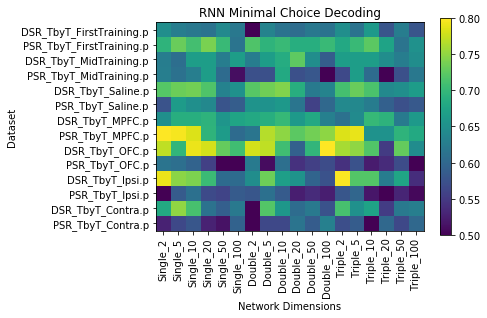

MAX SCORES ACHIEVED:
score: 0.66 - Triple_10 - DSR_TbyT_FirstTraining.p
score: 0.74 - Single_20 - PSR_TbyT_FirstTraining.p
score: 0.73 - Double_20 - DSR_TbyT_MidTraining.p
score: 0.68 - Double_10 - PSR_TbyT_MidTraining.p
score: 0.74 - Double_10 - DSR_TbyT_Saline.p
score: 0.66 - Single_5 - PSR_TbyT_Saline.p
score: 0.70 - Triple_10 - DSR_TbyT_MPFC.p
score: 0.81 - Single_2 - PSR_TbyT_MPFC.p
score: 0.80 - Double_100 - DSR_TbyT_OFC.p
score: 0.62 - Double_2 - PSR_TbyT_OFC.p
score: 0.80 - Triple_2 - DSR_TbyT_Ipsi.p
score: 0.61 - Single_10 - PSR_TbyT_Ipsi.p
score: 0.75 - Single_5 - DSR_TbyT_Contra.p
score: 0.63 - Double_100 - PSR_TbyT_Contra.p


In [7]:
scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binaryMinimal_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'RNN Minimal Choice Decoding')

OK, not huge differences but we do have some advances on 3 datasets. Mainly:

PSR - MidTraining - 0.65 to 0.68
DSR - Ipsi        - 0.76 to 0.80
DSR - Contra      - 0.71 to 0.75

The main difference is that we don't have terrible decoding on large chunks of the diagram as before. Maybe with more information, the networks overfit crazy stuff that isn't there that then generalizes terribly ? Unclear. We could go the other extreme now, and include *all* information available, including information not available to the rat, such as the correct answer, or other factors that should be irrelevant, e.g. start arms.  This will be called the binaryOmni sequence prepration.


In [ ]:
ROOT = '/Users/pablomartin/python/'
import os
import pickle
import numpy as np
import pandas as pd

from RNNmodule.SequenceClass import Sequences

source = ROOT + 'DATA_structures/TbyT/'
target = ROOT + 'DATA_structures/RNN_sequences/binaryOmni/'
seq_length = 20
RANDOM_STATE = 11

for dataset in [d for d in os.listdir(source) if not d.startswith('.')]:
    #create Sequence object
    SeqObject = Sequences('binary', 'by%i' %seq_length, RANDOM_STATE = RANDOM_STATE)
    #loading dataset
    df = pickle.load(open(source + dataset, 'rb'))
    #create sequences!
    SeqObject.create_sequences(df, timesteps = seq_length)
    #save object
    pickle.dump(SeqObject, open(target + dataset, 'wb'))
print 'DONE.'

## Omni Binary Model
Results for RNNs trained with all information thrown at it. 

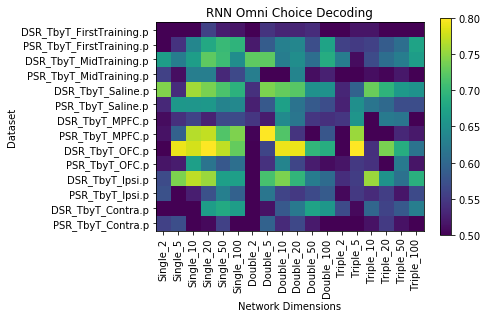

MAX SCORES ACHIEVED:
score: 0.56 - Single_20 - DSR_TbyT_FirstTraining.p
score: 0.70 - Single_50 - PSR_TbyT_FirstTraining.p
score: 0.73 - Double_2 - DSR_TbyT_MidTraining.p
score: 0.64 - Double_20 - PSR_TbyT_MidTraining.p
score: 0.76 - Single_10 - DSR_TbyT_Saline.p
score: 0.67 - Double_10 - PSR_TbyT_Saline.p
score: 0.66 - Triple_5 - DSR_TbyT_MPFC.p
score: 0.83 - Double_5 - PSR_TbyT_MPFC.p
score: 0.82 - Triple_5 - DSR_TbyT_OFC.p
score: 0.67 - Single_10 - PSR_TbyT_OFC.p
score: 0.77 - Single_10 - DSR_TbyT_Ipsi.p
score: 0.63 - Single_50 - PSR_TbyT_Ipsi.p
score: 0.68 - Single_50 - DSR_TbyT_Contra.p
score: 0.59 - Double_5 - PSR_TbyT_Contra.p


In [7]:
scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binaryOmni_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'RNN Omni Choice Decoding')

The more information you add, the higher the probability that your model will do really poorly. For the minimal RNNs, with only choice and reward information, most architectures would do well enough. Here, adding all information gives a lot of chance decoding, and some marginally better decoding for some datasets. In general, however, these models seemed to do worse. Now let's try both Minimal and Omni sequence preparation for an LSTM network.

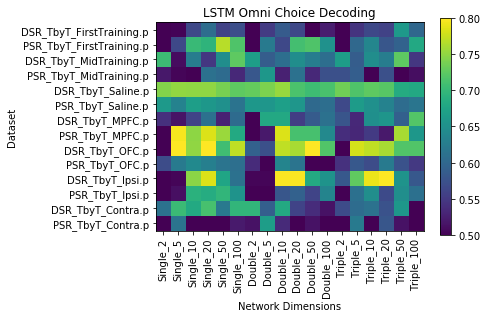

MAX SCORES ACHIEVED:
score: 0.66 - Triple_50 - DSR_TbyT_FirstTraining.p
score: 0.77 - Single_50 - PSR_TbyT_FirstTraining.p
score: 0.73 - Triple_50 - DSR_TbyT_MidTraining.p
score: 0.66 - Double_5 - PSR_TbyT_MidTraining.p
score: 0.75 - Double_10 - DSR_TbyT_Saline.p
score: 0.67 - Double_10 - PSR_TbyT_Saline.p
score: 0.72 - Triple_100 - DSR_TbyT_MPFC.p
score: 0.80 - Single_5 - PSR_TbyT_MPFC.p
score: 0.81 - Single_5 - DSR_TbyT_OFC.p
score: 0.64 - Single_10 - PSR_TbyT_OFC.p
score: 0.81 - Triple_20 - DSR_TbyT_Ipsi.p
score: 0.70 - Single_50 - PSR_TbyT_Ipsi.p
score: 0.71 - Single_20 - DSR_TbyT_Contra.p
score: 0.67 - Double_5 - PSR_TbyT_Contra.p


In [8]:
scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binaryOmni_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'LSTM Omni Choice Decoding')

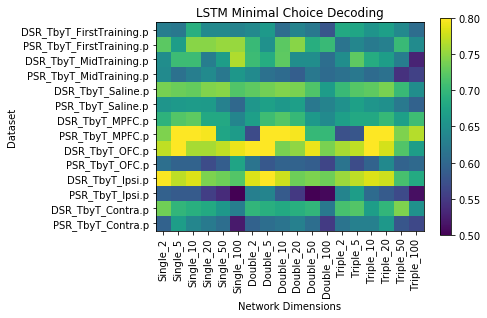

MAX SCORES ACHIEVED:
score: 0.69 - Single_10 - DSR_TbyT_FirstTraining.p
score: 0.75 - Single_50 - PSR_TbyT_FirstTraining.p
score: 0.76 - Single_100 - DSR_TbyT_MidTraining.p
score: 0.66 - Single_100 - PSR_TbyT_MidTraining.p
score: 0.75 - Single_50 - DSR_TbyT_Saline.p
score: 0.67 - Double_5 - PSR_TbyT_Saline.p
score: 0.73 - Single_10 - DSR_TbyT_MPFC.p
score: 0.83 - Double_10 - PSR_TbyT_MPFC.p
score: 0.81 - Double_2 - DSR_TbyT_OFC.p
score: 0.68 - Single_100 - PSR_TbyT_OFC.p
score: 0.84 - Double_5 - DSR_TbyT_Ipsi.p
score: 0.67 - Triple_5 - PSR_TbyT_Ipsi.p
score: 0.74 - Triple_50 - DSR_TbyT_Contra.p
score: 0.67 - Single_5 - PSR_TbyT_Contra.p


In [9]:
scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binaryMinimal_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'LSTM Minimal Choice Decoding')

Same pattern as above, the more information, the more "dark spots" we have in our plots. However large these networks are, and for what to me seems like ample time to learn the datasets (100 epochs), the models start to overfit with more information and generalize poorly. In a future experiment, we will have to see how early stopping affects this. Maybe the more data you have, trained lightly, is the best approach. We will see.

## Regularization via Dropout
So as we run more models we are getting marginal improvements for some datasets. This may be due to 'chance', however, because as you have more and more models that more or less fit the data well, some will do better than others based on luck. The true performance of the models will be on the test set, as here we are optimizing over the validation set so models are biased. So far, however, we have achieved better decoding accuracy than previous attempts with RNNs, except for 2/14 datasets where we are only 0.02 less.  

Our models may be overfitting, something we observed with the training epoch experiment above. To help this, we will include a type of regularization called "dropout". This technique "freezes" a randomly selected subsample of the neurons of a particular layer to not be updated during an epoch. This forces the rest of the neurons to learn from this batch/epoch more, whilst on the next epoch, a different subset of neurons will have to learn more. We will add a 20% dropout between every layer of the model, for all 6 versions: original, Omni, and Minimal sequence preparation, and for networks with RNN cells or LSTM cells. By this point, I've streamlined the process so everything is done epsilon-side and only the performance scores are sent back this way. Below are results. 

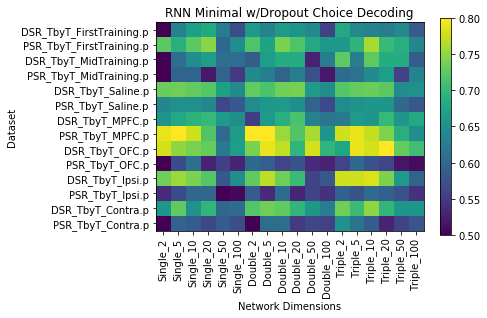

MAX SCORES ACHIEVED:
score: 0.68 - Single_20 - DSR_TbyT_FirstTraining.p
score: 0.76 - Triple_10 - PSR_TbyT_FirstTraining.p
score: 0.73 - Triple_2 - DSR_TbyT_MidTraining.p
score: 0.67 - Triple_20 - PSR_TbyT_MidTraining.p
score: 0.74 - Double_20 - DSR_TbyT_Saline.p
score: 0.66 - Double_10 - PSR_TbyT_Saline.p
score: 0.71 - Double_20 - DSR_TbyT_MPFC.p
score: 0.81 - Double_2 - PSR_TbyT_MPFC.p
score: 0.80 - Triple_20 - DSR_TbyT_OFC.p
score: 0.61 - Single_10 - PSR_TbyT_OFC.p
score: 0.78 - Triple_10 - DSR_TbyT_Ipsi.p
score: 0.60 - Double_10 - PSR_TbyT_Ipsi.p
score: 0.75 - Triple_10 - DSR_TbyT_Contra.p
score: 0.65 - Triple_2 - PSR_TbyT_Contra.p


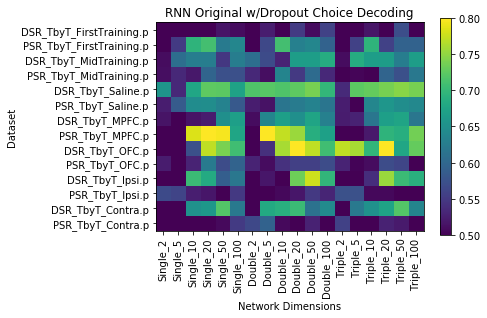

MAX SCORES ACHIEVED:
score: 0.57 - Triple_50 - DSR_TbyT_FirstTraining.p
score: 0.71 - Double_10 - PSR_TbyT_FirstTraining.p
score: 0.69 - Double_100 - DSR_TbyT_MidTraining.p
score: 0.64 - Double_10 - PSR_TbyT_MidTraining.p
score: 0.75 - Triple_50 - DSR_TbyT_Saline.p
score: 0.66 - Triple_20 - PSR_TbyT_Saline.p
score: 0.68 - Double_50 - DSR_TbyT_MPFC.p
score: 0.81 - Double_5 - PSR_TbyT_MPFC.p
score: 0.81 - Double_20 - DSR_TbyT_OFC.p
score: 0.62 - Single_20 - PSR_TbyT_OFC.p
score: 0.78 - Double_50 - DSR_TbyT_Ipsi.p
score: 0.57 - Triple_2 - PSR_TbyT_Ipsi.p
score: 0.72 - Single_50 - DSR_TbyT_Contra.p
score: 0.59 - Double_5 - PSR_TbyT_Contra.p


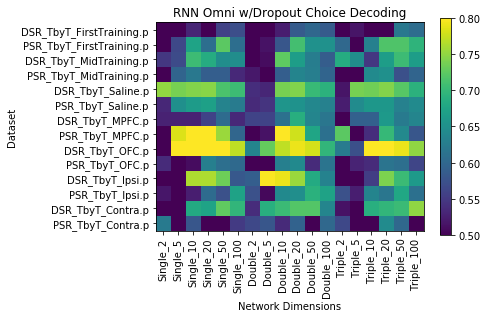

MAX SCORES ACHIEVED:
score: 0.62 - Triple_50 - DSR_TbyT_FirstTraining.p
score: 0.72 - Single_50 - PSR_TbyT_FirstTraining.p
score: 0.73 - Double_10 - DSR_TbyT_MidTraining.p
score: 0.65 - Triple_20 - PSR_TbyT_MidTraining.p
score: 0.75 - Single_2 - DSR_TbyT_Saline.p
score: 0.67 - Single_20 - PSR_TbyT_Saline.p
score: 0.69 - Double_20 - DSR_TbyT_MPFC.p
score: 0.82 - Double_10 - PSR_TbyT_MPFC.p
score: 0.81 - Single_50 - DSR_TbyT_OFC.p
score: 0.64 - Double_20 - PSR_TbyT_OFC.p
score: 0.80 - Double_5 - DSR_TbyT_Ipsi.p
score: 0.69 - Double_50 - PSR_TbyT_Ipsi.p
score: 0.75 - Triple_100 - DSR_TbyT_Contra.p
score: 0.64 - Triple_20 - PSR_TbyT_Contra.p


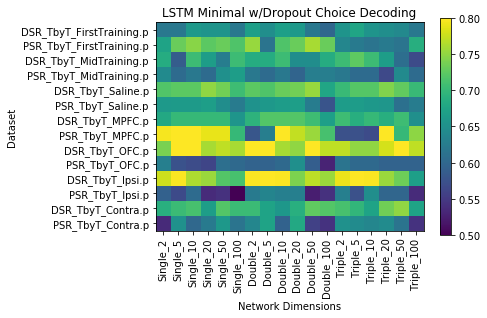

MAX SCORES ACHIEVED:
score: 0.68 - Triple_5 - DSR_TbyT_FirstTraining.p
score: 0.76 - Double_50 - PSR_TbyT_FirstTraining.p
score: 0.73 - Triple_5 - DSR_TbyT_MidTraining.p
score: 0.67 - Single_100 - PSR_TbyT_MidTraining.p
score: 0.75 - Double_50 - DSR_TbyT_Saline.p
score: 0.67 - Single_20 - PSR_TbyT_Saline.p
score: 0.72 - Double_5 - DSR_TbyT_MPFC.p
score: 0.84 - Single_5 - PSR_TbyT_MPFC.p
score: 0.82 - Single_5 - DSR_TbyT_OFC.p
score: 0.65 - Double_20 - PSR_TbyT_OFC.p
score: 0.83 - Double_5 - DSR_TbyT_Ipsi.p
score: 0.65 - Triple_10 - PSR_TbyT_Ipsi.p
score: 0.75 - Triple_50 - DSR_TbyT_Contra.p
score: 0.68 - Double_20 - PSR_TbyT_Contra.p


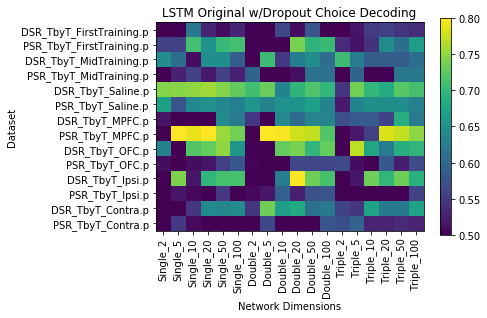

MAX SCORES ACHIEVED:
score: 0.62 - Single_10 - DSR_TbyT_FirstTraining.p
score: 0.74 - Double_20 - PSR_TbyT_FirstTraining.p
score: 0.71 - Double_5 - DSR_TbyT_MidTraining.p
score: 0.62 - Triple_50 - PSR_TbyT_MidTraining.p
score: 0.76 - Single_20 - DSR_TbyT_Saline.p
score: 0.67 - Single_2 - PSR_TbyT_Saline.p
score: 0.69 - Triple_50 - DSR_TbyT_MPFC.p
score: 0.82 - Single_20 - PSR_TbyT_MPFC.p
score: 0.77 - Triple_5 - DSR_TbyT_OFC.p
score: 0.58 - Single_100 - PSR_TbyT_OFC.p
score: 0.80 - Double_20 - DSR_TbyT_Ipsi.p
score: 0.59 - Double_10 - PSR_TbyT_Ipsi.p
score: 0.73 - Double_5 - DSR_TbyT_Contra.p
score: 0.59 - Triple_5 - PSR_TbyT_Contra.p


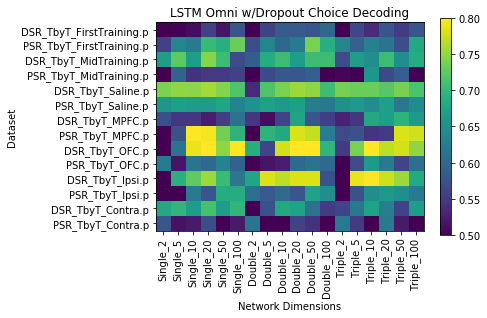

MAX SCORES ACHIEVED:
score: 0.60 - Double_100 - DSR_TbyT_FirstTraining.p
score: 0.74 - Double_50 - PSR_TbyT_FirstTraining.p
score: 0.75 - Single_20 - DSR_TbyT_MidTraining.p
score: 0.66 - Triple_10 - PSR_TbyT_MidTraining.p
score: 0.76 - Single_20 - DSR_TbyT_Saline.p
score: 0.68 - Single_50 - PSR_TbyT_Saline.p
score: 0.69 - Triple_50 - DSR_TbyT_MPFC.p
score: 0.82 - Single_10 - PSR_TbyT_MPFC.p
score: 0.82 - Single_100 - DSR_TbyT_OFC.p
score: 0.66 - Triple_10 - PSR_TbyT_OFC.p
score: 0.80 - Triple_10 - DSR_TbyT_Ipsi.p
score: 0.69 - Single_50 - PSR_TbyT_Ipsi.p
score: 0.71 - Single_20 - DSR_TbyT_Contra.p
score: 0.62 - Triple_2 - PSR_TbyT_Contra.p


In [26]:
#RNNs ________

scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binaryMinimalDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'RNN Minimal w/Dropout Choice Decoding')
scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binaryDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'RNN Original w/Dropout Choice Decoding')
scores = pickle.load(open(ROOT + 'Model_Evaluation/RNN/binaryOmniDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'RNN Omni w/Dropout Choice Decoding')
#LSTMs ________
scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binaryMinimalDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'LSTM Minimal w/Dropout Choice Decoding')
scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binaryDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'LSTM Original w/Dropout Choice Decoding')
scores = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/binaryOmniDropout_classification_behavior.p', 'rb'))
plot_model_performance(scores, 'LSTM Omni w/Dropout Choice Decoding')


This is a lot of models ! Only 2 beat the highest scores so far, and again, this is not definitive, but rather we'll have to wait and see what performance looks like on the test set. For now, we are done training models. Below, we gather the best performing models over all variations tried in this notebook, and do that pesky final score on the test set. Let's get ready to be a bit dissapointed, performance will drop, let's just hope that it doesn't drop too much. 

In [44]:
import pysftp
datatype = ['binary', 'binaryMinimal', 'binaryOmni',
            'full_binary', 'full_binaryMinimal', 'full_binaryOmni']

ROOT = '/home/pablo/python/' #epsilon side
LSTM_dir = 'Models/LSTM/Pablo/'
RNN_dir = 'Models/RNN/'

attr = ['sequences', 'model_path', 'val_score', 'test_score']
BEST_OF = pd.DataFrame(np.zeros([len(fileNames), len(attr)]),
                       index = fileNames,
                       columns = attr)

seq_types = ['binary', 'binaryMinimal', 'binaryOmni']
model_types = ['binary/', 'binaryMinimal/', 'binaryOmni/',
               'binaryDropout/', 'binaryMinimalDropout/', 'binaryOmniDropout/']

def fileName2model(fileName, hd):
    return fileName[:-2] + str(hd) + '.h5'

#yes, we're doing this by hand
# DSR _______________
BEST_OF.loc['DSR_TbyT_FirstTraining.p', 'sequences'] = seq_types[1]
BEST_OF.loc['DSR_TbyT_MidTraining.p', 'sequences'] = seq_types[0]
BEST_OF.loc['DSR_TbyT_Saline.p', 'sequences'] = seq_types[2]
BEST_OF.loc['DSR_TbyT_MPFC.p', 'sequences'] = seq_types[1]
BEST_OF.loc['DSR_TbyT_OFC.p', 'sequences'] = seq_types[2]
BEST_OF.loc['DSR_TbyT_Ipsi.p', 'sequences'] = seq_types[1]
BEST_OF.loc['DSR_TbyT_Contra.p', 'sequences'] = seq_types[1]
# PSR ________________
BEST_OF.loc['PSR_TbyT_FirstTraining.p', 'sequences'] = seq_types[2]
BEST_OF.loc['PSR_TbyT_MidTraining.p', 'sequences'] = seq_types[1]
BEST_OF.loc['PSR_TbyT_Saline.p', 'sequences'] = seq_types[2]
BEST_OF.loc['PSR_TbyT_MPFC.p', 'sequences'] = seq_types[1]
BEST_OF.loc['PSR_TbyT_OFC.p', 'sequences'] = seq_types[1]
BEST_OF.loc['PSR_TbyT_Ipsi.p', 'sequences'] = seq_types[2]
BEST_OF.loc['PSR_TbyT_Contra.p', 'sequences'] = seq_types[1]

# DSR _______________WINNING MODELS
BEST_OF.loc['DSR_TbyT_FirstTraining.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[1] + 'Single/' +  fileName2model('DSR_TbyT_FirstTraining.p', 10)
    
BEST_OF.loc['DSR_TbyT_MidTraining.p', 'model_path'] = \
        ROOT + RNN_dir + model_types[0] + 'Double/' +  fileName2model('DSR_TbyT_MidTraining.p', 10)
    
BEST_OF.loc['DSR_TbyT_Saline.p', 'model_path'] = \
        ROOT + RNN_dir + model_types[2] + 'Single/' +  fileName2model('DSR_TbyT_Saline.p', 10)
    
BEST_OF.loc['DSR_TbyT_MPFC.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[1] + 'Single/' +  fileName2model('DSR_TbyT_MPFC.p', 10)
    
BEST_OF.loc['DSR_TbyT_OFC.p', 'model_path'] = \
        ROOT + RNN_dir + model_types[2] + 'Triple/' +  fileName2model('DSR_TbyT_OFC.p', 5)
    
BEST_OF.loc['DSR_TbyT_Ipsi.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[1] + 'Double/' +  fileName2model('DSR_TbyT_Ipsi.p', 5)
    
BEST_OF.loc['DSR_TbyT_Contra.p', 'model_path'] = \
        ROOT + RNN_dir + model_types[1] + 'Single/' +  fileName2model('DSR_TbyT_Contra.p', 5)

# PSR _______________WINNING MODELS
BEST_OF.loc['PSR_TbyT_FirstTraining.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[2] + 'Single/' +  fileName2model('PSR_TbyT_FirstTraining.p', 50)
    
BEST_OF.loc['PSR_TbyT_MidTraining.p', 'model_path'] = \
        ROOT + RNN_dir + model_types[1] + 'Double/' +  fileName2model('PSR_TbyT_MidTraining.p', 10)
    
BEST_OF.loc['PSR_TbyT_Saline.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[5] + 'Single/' +  fileName2model('PSR_TbyT_Saline.p', 50)
    
BEST_OF.loc['PSR_TbyT_MPFC.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[4] + 'Single/' +  fileName2model('PSR_TbyT_MPFC.p', 5)
    
BEST_OF.loc['PSR_TbyT_OFC.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[1] + 'Single/' +  fileName2model('PSR_TbyT_OFC.p', 100)
    
BEST_OF.loc['PSR_TbyT_Ipsi.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[2] + 'Single/' +  fileName2model('PSR_TbyT_Ipsi.p', 50)
    
BEST_OF.loc['PSR_TbyT_Contra.p', 'model_path'] = \
        ROOT + LSTM_dir + model_types[4] + 'Double/' +  fileName2model('PSR_TbyT_Contra.p', 20)

#opening SFTP connection
srv = pysftp.Connection(host = "10.81.104.156", username = "pablo", password = "pablo2014")
winner_folder = '/Users/pablomartin/python/Models/Winners/'
os.chdir(winner_folder)
for fileName in fileNames:
    srv.get(BEST_OF.loc[fileName, 'model_path'])
    print 'downloaded %s ...' %BEST_OF.loc[fileName, 'model_path']
#closing connection
srv.close()
#returning to home directory 
os.chdir('/Users/pablomartin/python/')
print 'DONE.'

downloaded /home/pablo/python/Models/LSTM/Pablo/binaryMinimal/Single/DSR_TbyT_FirstTraining10.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryOmni/Single/PSR_TbyT_FirstTraining50.h5 ...
downloaded /home/pablo/python/Models/RNN/binary/Double/DSR_TbyT_MidTraining10.h5 ...
downloaded /home/pablo/python/Models/RNN/binaryMinimal/Double/PSR_TbyT_MidTraining10.h5 ...
downloaded /home/pablo/python/Models/RNN/binaryOmni/Single/DSR_TbyT_Saline10.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryOmniDropout/Single/PSR_TbyT_Saline50.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryMinimal/Single/DSR_TbyT_MPFC10.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryMinimalDropout/Single/PSR_TbyT_MPFC5.h5 ...
downloaded /home/pablo/python/Models/RNN/binaryOmni/Triple/DSR_TbyT_OFC5.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryMinimal/Single/PSR_TbyT_OFC100.h5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binaryMinimal/Double/DSR_TbyT_Ip

In [47]:
from keras.models import load_model

winner_folder = '/Users/pablomartin/python/Models/Winners/'
final_scores = pd.DataFrame(np.zeros([len(fileNames), 2]), index = fileNames, columns = ['val', 'test'])

#go thru each dataset
for fileName in fileNames:
    #load the right sequences
    sequence_path = '/Users/pablomartin/python/DATA_structures/RNN_sequences/' \
    + BEST_OF.loc[fileName, 'sequences'] + '/' + fileName
    seqs = pickle.load(open(sequence_path, 'rb'))
    
    #find the right model
    for files_in_folder in os.listdir(winner_folder):
        if files_in_folder.startswith(fileName[:-2]) > 0:
            model = load_model(winner_folder + files_in_folder)
   
    #evaluate model on data
    val_scores = model.evaluate(seqs.X_validate, seqs.y_validate)
    test_scores = model.evaluate(seqs.X_test, seqs.y_test)
    final_scores.loc[fileName, 'val'] = val_scores[1]
    final_scores.loc[fileName, 'test'] = test_scores[1]
    
print final_scores

176/176 [==============================] - 0s 940us/step
                               val      test
DSR_TbyT_FirstTraining.p  0.689655  0.720000
PSR_TbyT_FirstTraining.p  0.768116  0.655556
DSR_TbyT_MidTraining.p    0.764706  0.640625
PSR_TbyT_MidTraining.p    0.682171  0.631068
DSR_TbyT_Saline.p         0.758621  0.750405
PSR_TbyT_Saline.p         0.677746  0.691667
DSR_TbyT_MPFC.p           0.726115  0.733333
PSR_TbyT_MPFC.p           0.838323  0.339806
DSR_TbyT_OFC.p            0.822917  0.700637
PSR_TbyT_OFC.p            0.675497  0.588235
DSR_TbyT_Ipsi.p           0.841727  0.693878
PSR_TbyT_Ipsi.p           0.697531  0.573770
DSR_TbyT_Contra.p         0.750000  0.735632
PSR_TbyT_Contra.p         0.681159  0.625000


## Conclusions - Model Grid
### Validation vs. Test Scores

We can already see that overfitting is a *HUGE* problem. For example, look at one of the best performing models, PSR_MPFC. Validation score is 0.83, whilst test score is 0.33. Abysmal. Enough said.

	testing on dataset DSR_TbyT_FirstTraining.p
50/50 [==============================] - 0s 604us/step
	testing on dataset PSR_TbyT_FirstTraining.p
967/967 [==============================] - 0s 443us/step
	testing on dataset DSR_TbyT_MidTraining.p
938/938 [==============================] - 0s 432us/step
	testing on dataset PSR_TbyT_MidTraining.p
1153/1153 [==============================] - 1s 450us/step
	testing on dataset DSR_TbyT_Saline.p
4325/4325 [==============================] - 2s 448us/step
	testing on dataset PSR_TbyT_Saline.p
5206/5206 [==============================] - 2s 446us/step
	testing on dataset DSR_TbyT_MPFC.p
1615/1615 [==============================] - 1s 434us/step
	testing on dataset PSR_TbyT_MPFC.p
1694/1694 [==============================] - 1s 415us/step
	testing on dataset DSR_TbyT_OFC.p
1233/1233 [==============================] - 1s 419us/step
	testing on dataset PSR_TbyT_OFC.p
1249/1249 [==============================] - 1s 430us/step
	testing on dataset DSR_

	testing on dataset DSR_TbyT_OFC.p
1233/1233 [==============================] - 1s 585us/step
	testing on dataset PSR_TbyT_OFC.p
1249/1249 [==============================] - 1s 595us/step
	testing on dataset DSR_TbyT_Ipsi.p
1351/1351 [==============================] - 1s 588us/step
	testing on dataset PSR_TbyT_Ipsi.p
183/183 [==============================] - 0s 600us/step
	testing on dataset DSR_TbyT_Contra.p
1439/1439 [==============================] - 1s 551us/step
	testing on dataset PSR_TbyT_Contra.p
1425/1425 [==============================] - 1s 534us/step
	testing on dataset DSR_TbyT_FirstTraining.p
843/843 [==============================] - 4s 4ms/step
	testing on dataset PSR_TbyT_FirstTraining.p
967/967 [==============================] - 0s 216us/step
	testing on dataset DSR_TbyT_MidTraining.p
938/938 [==============================] - 0s 208us/step
	testing on dataset PSR_TbyT_MidTraining.p
1153/1153 [==============================] - 0s 221us/step
	testing on dataset DSR_Tb

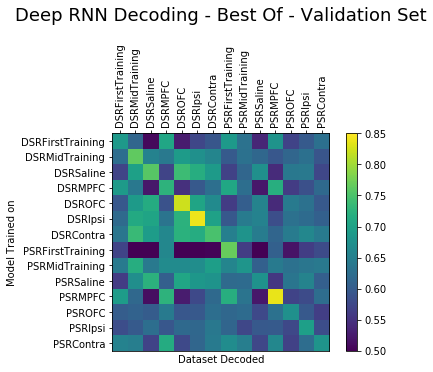

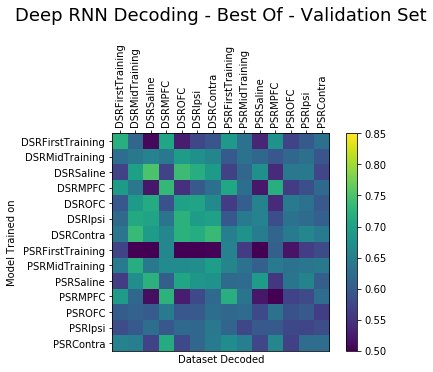

In [49]:
from Visualize.decoding import *
model_grid_validation = create_model_grid()
model_grid_test = create_model_grid()
idx = pd.IndexSlice

def fileName2labels(fileName):
    tmp = fileName[-fileName[::-1].find('_'):]
    return fileName[:3], tmp[:-2]

for fileName in fileNames:
    print 'testing model trained on %s' %fileName
    #find the right model
    for files_in_folder in os.listdir(winner_folder):
        if files_in_folder.startswith(fileName[:-2]) > 0:
            model = load_model(winner_folder + files_in_folder)
   
    #determine the right *type* of sequences
    sequence_path_dir = '/Users/pablomartin/python/DATA_structures/RNN_sequences/' \
    + BEST_OF.loc[fileName, 'sequences'] + '/' 
    
    for compFileName in fileNames:
        print '\ttesting on dataset %s' %compFileName
        seqs = pickle.load(open(sequence_path_dir + compFileName, 'rb'))
        if fileName == compFileName:
            #evaluate model on data
            val_scores = model.evaluate(seqs.X_validate, seqs.y_validate)
            test_scores = model.evaluate(seqs.X_test, seqs.y_test)
            model_grid_validation.loc[idx[fileName2labels(fileName)],
                                      idx[fileName2labels(compFileName)]] = val_scores[1]
            model_grid_test.loc[idx[fileName2labels(fileName)],
                                idx[fileName2labels(compFileName)]] = test_scores[1]
        else:
            X = np.concatenate([seqs.X_train, seqs.X_validate, seqs.X_test])
            y = np.concatenate([seqs.y_train, seqs.y_validate, seqs.y_test])
            val_scores = model.evaluate(X, y)
            model_grid_validation.loc[idx[fileName2labels(fileName)],
                                      idx[fileName2labels(compFileName)]] = val_scores[1]
            model_grid_test.loc[idx[fileName2labels(fileName)],
                                idx[fileName2labels(compFileName)]] = val_scores[1]


plot_model_grid(model_grid_validation, [0.5, 0.85], title = 'Deep RNN Decoding - Best Of - Validation Set')
plot_model_grid(model_grid_test, [0.5, 0.85], title = 'Deep RNN Decoding - Best Of - Validation Set')
pickle.dump(model_grid_validation,
            open('/Users/pablomartin/python/Model_Evaluation/LSTM/model_grid_BEST_OF_validation.p', 'wb'))
pickle.dump(model_grid_test,
            open('/Users/pablomartin/python/Model_Evaluation/LSTM/model_grid_BEST_OF_test.p', 'wb'))

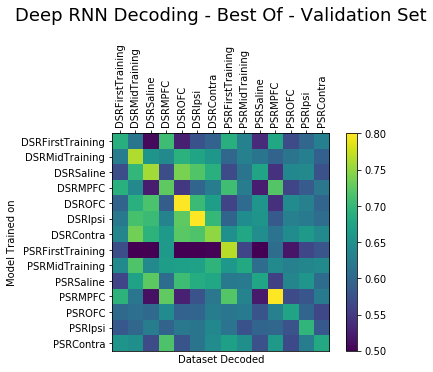

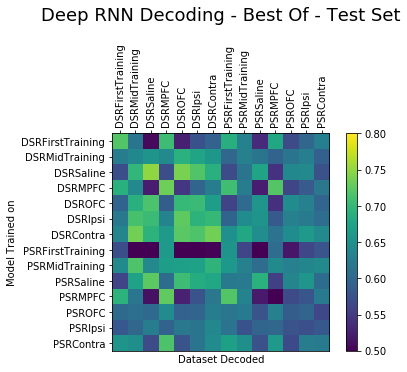

In [58]:
val = pickle.load(open('/Users/pablomartin/python/Model_Evaluation/LSTM/model_grid_BEST_OF_validation.p', 'rb'))
test = pickle.load(open('/Users/pablomartin/python/Model_Evaluation/LSTM/model_grid_BEST_OF_test.p', 'rb'))
plot_model_grid(val, [0.5, 0.8], title = 'Deep RNN Decoding - Best Of - Validation Set')
plot_model_grid(test, [0.5, 0.8], title = 'Deep RNN Decoding - Best Of - Test Set')

And we are done.

# MEGA ADDENDUM
Of course we couldn't leave it there. Instead, we added 2 more datasets: naive animals with mPFC inactivation, and naive animals with OFC inactivation, and added the saline sessions to the Naive Animals DSR. Then we trained the biggest batch of networks so far. We used early stopping by monitoring the validation set accuracy with patience 10, so that if the model had not improved after 10 epochs, training would stop. Furthermore, we saved a model if it was the best-performing on the validation set so far. We searched the following parameter space in terms of networks:  

1) RNN or LSTM cells  
2) Sequences were either 20 trials long or 200 (padded with 0s)  
3) Sequences included either just:  
    a) choice and reward  
    b) additionally: reaction times to initiate trial, make choice, and trial # of session  
    c) additionally: start arms, goal arms, trials into block  
4) networks had 1-3 layers with varying combinations of hidden units in each layer for a total of 69 combinations  

In total we trained 13248 networks, so 828 networks per dataset. This is as comprehensive as we are going to get, and it's been running on epsilon for about 2 days now and is almost done. We calculate best performing networks over there and just download the 'winning' networks. 

In [ ]:

#opening SFTP connection
os.chdir('/Users/pablomartin/python/Model_Evaluation/LSTM/')
srv = pysftp.Connection(host = "10.81.104.156", username = "pablo", password = "pablo2014")
srv.get('/home/pablo/python/Model_Evaluation/RNN/BEST_OF_GIANT_RUN.p')
print 'downloaded results...'
print 'loading results...'
BEST_OF = pickle.load(open(ROOT + 'Model_Evaluation/LSTM/BEST_OF_GIANT_RUN.p' , 'rb'))


OK, now we download only the best performing models. For now, we will have 2 winners folders which we can fix, because ideally that folder should only contain the best model so far. We may have to edit a lot of this code to add the best K models so that we can use stacked or ensemble methods. Let's ask Jake about this. 

In [7]:
winner_folder = '/Users/pablomartin/python/Models/Winners2/'
os.chdir(winner_folder)
for fileName in BEST_OF.index:
    srv.get(BEST_OF.loc[fileName, 'model_path'], fileName)
    print 'downloaded %s ...' %BEST_OF.loc[fileName, 'model_path']
#closing connection
srv.close()
#returning to home directory 
os.chdir('/Users/pablomartin/python/')
print 'DONE.'


downloaded /home/pablo/python/Models/LSTM/Pablo/full_binaryMinimal/DSR_TbyT_FirstTraining_D_100/weights.19-0.78.hdf5 ...
downloaded /home/pablo/python/Models/RNN/full_binaryMinimal/PSR_TbyT_FirstTraining_D_5_D_100/weights.25-0.78.hdf5 ...
downloaded /home/pablo/python/Models/RNN/binaryOmni/DSR_TbyT_MidTraining_D_50_D_100/weights.29-0.80.hdf5 ...
downloaded /home/pablo/python/Models/RNN/binaryMinimal/PSR_TbyT_MidTraining_D_20_D_100/weights.20-0.72.hdf5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binary/DSR_TbyT_Saline_D_50/weights.90-0.77.hdf5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/binary/PSR_TbyT_Saline_D_20_D_50/weights.67-0.68.hdf5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/full_binaryMinimal/DSR_TbyT_MPFC_D_10_D_50/weights.31-0.76.hdf5 ...
downloaded /home/pablo/python/Models/LSTM/Pablo/full_binaryMinimal/PSR_TbyT_MPFC_D_10/weights.18-0.86.hdf5 ...
downloaded /home/pablo/python/Models/RNN/full_binaryOmni/DSR_TbyT_OFC_D_100_D_20/weights.37-0.83.hdf5 ...


In [10]:
model_grid_validation = flat_model_grid()
model_grid_test = flat_model_grid()

for fileName_index, fileName in enumerate(fileNames):
    print 'testing model trained on %s' %fileName
    #find the right model
    for files_in_folder in os.listdir(winner_folder):
        if files_in_folder.startswith(fileName[:-2]) > 0:
            model = load_model(winner_folder + files_in_folder)
   
    #determine the right *type* of sequences
    sequence_path_dir = '/Users/pablomartin/python/DATA_structures/RNN_sequences/' \
    + BEST_OF.loc[fileName, 'sequences'] + '/' 
    
    for compFileName_index, compFileName in enumerate(fileNames):
        print '\ttesting on dataset %s' %compFileName
        seqs = pickle.load(open(sequence_path_dir + compFileName, 'rb'))
        if fileName == compFileName:
            #evaluate model on data
            val_scores = model.evaluate(seqs.X_validate, seqs.y_validate)
            test_scores = model.evaluate(seqs.X_test, seqs.y_test)
            model_grid_validation.loc[idx[fileNameLabels[fileName_index]],
                                      idx[fileNameLabels[compFileName_index]]] = val_scores[1]
            model_grid_test.loc[idx[fileNameLabels[fileName_index]],
                                idx[fileNameLabels[compFileName_index]]] = test_scores[1]
        else:
            X = np.concatenate([seqs.X_train, seqs.X_validate, seqs.X_test])
            y = np.concatenate([seqs.y_train, seqs.y_validate, seqs.y_test])
            val_scores = model.evaluate(X, y)
            model_grid_validation.loc[idx[fileNameLabels[fileName_index]],
                                      idx[fileNameLabels[compFileName_index]]] = val_scores[1]
            model_grid_test.loc[idx[fileNameLabels[fileName_index]],
                                idx[fileNameLabels[compFileName_index]]] = val_scores[1]


pickle.dump(model_grid_validation,
            open('/Users/pablomartin/python/Model_Evaluation/LSTM/GIANT_model_grid_BEST_OF_validation.p', 'wb'))
pickle.dump(model_grid_test,
            open('/Users/pablomartin/python/Model_Evaluation/LSTM/GIANT_model_grid_BEST_OF_test.p', 'wb'))
print 'DONE.'

testing model trained on DSR_TbyT_FirstTraining.p
	testing on dataset DSR_TbyT_FirstTraining.p
179/179 [==============================] - 1s 3ms/step
	testing on dataset DSR_TbyT_Naive_mPFC.p
524/524 [==============================] - 2s 3ms/step
	testing on dataset DSR_TbyT_Naive_OFC.p
349/349 [==============================] - 1s 3ms/step
	testing on dataset DSR_TbyT_MidTraining.p
938/938 [==============================] - 3s 3ms/step
	testing on dataset DSR_TbyT_Saline.p
4325/4325 [==============================] - 13s 3ms/step
	testing on dataset DSR_TbyT_MPFC.p
1615/1615 [==============================] - 5s 3ms/step
	testing on dataset DSR_TbyT_OFC.p
1233/1233 [==============================] - 3s 3ms/step
	testing on dataset DSR_TbyT_Ipsi.p
1351/1351 [==============================] - 4s 3ms/step
	testing on dataset DSR_TbyT_Contra.p
1439/1439 [==============================] - 4s 3ms/step
	testing on dataset PSR_TbyT_FirstTraining.p
967/967 [==============================] - 3s

1425/1425 [==============================] - 1s 511us/step
testing model trained on DSR_TbyT_MPFC.p
	testing on dataset DSR_TbyT_FirstTraining.p
1243/1243 [==============================] - 10s 8ms/step
	testing on dataset DSR_TbyT_Naive_mPFC.p
524/524 [==============================] - 4s 8ms/step
	testing on dataset DSR_TbyT_Naive_OFC.p
349/349 [==============================] - 3s 8ms/step
	testing on dataset DSR_TbyT_MidTraining.p
938/938 [==============================] - 8s 8ms/step
	testing on dataset DSR_TbyT_Saline.p
4325/4325 [==============================] - 37s 8ms/step
	testing on dataset DSR_TbyT_MPFC.p
165/165 [==============================] - 2s 9ms/step
	testing on dataset DSR_TbyT_OFC.p
1233/1233 [==============================] - 11s 9ms/step
	testing on dataset DSR_TbyT_Ipsi.p
1351/1351 [==============================] - 11s 8ms/step
	testing on dataset DSR_TbyT_Contra.p
1439/1439 [==============================] - 12s 9ms/step
	testing on dataset PSR_TbyT_FirstTr

1425/1425 [==============================] - 13s 9ms/step
testing model trained on PSR_TbyT_Contra.p
	testing on dataset DSR_TbyT_FirstTraining.p
1243/1243 [==============================] - 19s 15ms/step
	testing on dataset DSR_TbyT_Naive_mPFC.p
524/524 [==============================] - 7s 14ms/step
	testing on dataset DSR_TbyT_Naive_OFC.p
349/349 [==============================] - 5s 14ms/step
	testing on dataset DSR_TbyT_MidTraining.p
938/938 [==============================] - 15s 16ms/step
	testing on dataset DSR_TbyT_Saline.p
4325/4325 [==============================] - 62s 14ms/step
	testing on dataset DSR_TbyT_MPFC.p
1615/1615 [==============================] - 26s 16ms/step
	testing on dataset DSR_TbyT_OFC.p
1233/1233 [==============================] - 18s 14ms/step
	testing on dataset DSR_TbyT_Ipsi.p
1351/1351 [==============================] - 22s 16ms/step
	testing on dataset DSR_TbyT_Contra.p
1439/1439 [==============================] - 21s 14ms/step
	testing on dataset PS

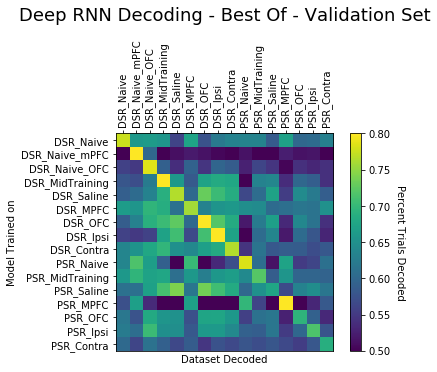

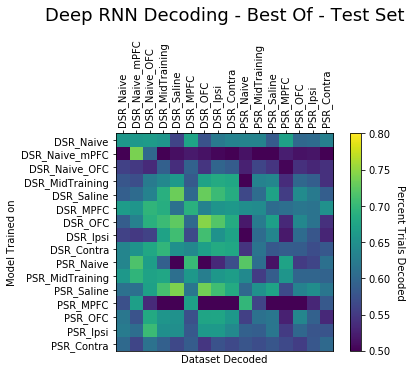

In [16]:
val = pickle.load(open('/Users/pablomartin/python/Model_Evaluation/LSTM/GIANT_model_grid_BEST_OF_validation.p', 'rb'))
test = pickle.load(open('/Users/pablomartin/python/Model_Evaluation/LSTM/GIANT_model_grid_BEST_OF_test.p', 'rb'))
plot_flat_model_grid(val, [0.5, 0.8], title = 'Deep RNN Decoding - Best Of - Validation Set')
plot_flat_model_grid(test, [0.5, 0.8], title = 'Deep RNN Decoding - Best Of - Test Set')